In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import Dataset, DataLoader

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


### basic RNN

In [226]:
# input_size – The number of expected features in the input x
# hidden_size – The number of features in the hidden state h
# num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, with the second GRU taking in outputs of the first GRU and computing the final results. Default: 1
rnn = nn.GRU(10, 20, 2)

## input data : sequence length , batch size , Hin
input = torch.randn(5, 3, 10)

## initial hidden state for the input sequence
h0 = torch.randn(2, 3, 20)


output, hn = rnn(input, h0)

In [227]:
## output of the last element for each batch
output[-1,:,:]

tensor([[-0.1410, -0.0244, -0.0114, -0.1652,  0.2008, -0.4866,  0.1948, -0.3686,
         -0.0619, -0.1607, -0.0314, -0.1700,  0.2453, -0.0700,  0.2141, -0.2971,
          0.0807,  0.0702, -0.0469, -0.0449],
        [-0.0905, -0.0125, -0.0081, -0.0299,  0.1285, -0.4196,  0.2351, -0.4542,
          0.1982, -0.2777, -0.0134, -0.2162, -0.0828, -0.1422, -0.0150,  0.0030,
          0.1734,  0.0247, -0.0127, -0.0231],
        [-0.2443, -0.0641,  0.2381, -0.0982,  0.0118, -0.1624,  0.4691, -0.5002,
          0.2875, -0.3131,  0.1864, -0.1490,  0.0924, -0.3016,  0.0367,  0.3347,
         -0.0323, -0.0166, -0.1118, -0.1859]], grad_fn=<SliceBackward0>)

In [228]:
output.dtype

torch.float32

### one-hot encoding > RNN

In [229]:
seq ="AUGCCCCAGAUUNN"

seq2n = {"A":0,"U":1,"G":2,"C":3,"N":4}


seq_tensor = torch.LongTensor( [seq2n[x] for x in seq] )


In [230]:
seq_tensor_OH = nn.functional.one_hot( seq_tensor , num_classes = 5 )
seq_tensor_OH = seq_tensor_OH.type('torch.FloatTensor')

In [231]:
seq_tensor_OH.dtype

torch.float32

In [232]:
inputSize_GRU = 5 
outputSize_GRU = 2


rnn = nn.GRU(inputSize_GRU, outputSize_GRU, 1)
output , _ = rnn(seq_tensor_OH)
output

tensor([[ 0.2133, -0.0309],
        [ 0.5421, -0.2301],
        [ 0.4051, -0.2710],
        [ 0.3645, -0.2742],
        [ 0.3510, -0.2712],
        [ 0.3464, -0.2676],
        [ 0.3448, -0.2647],
        [ 0.3840, -0.2279],
        [ 0.3299, -0.2643],
        [ 0.3779, -0.2269],
        [ 0.6355, -0.3773],
        [ 0.7647, -0.4885],
        [ 0.6573, -0.4093],
        [ 0.6201, -0.3429]], grad_fn=<SqueezeBackward1>)

### RNN > classifier

In [233]:
classif = nn.Sequential(nn.Linear( outputSize_GRU,1 ) , nn.Sigmoid())

classif(output)

tensor([[0.4352],
        [0.5172],
        [0.5044],
        [0.4990],
        [0.4965],
        [0.4952],
        [0.4945],
        [0.4938],
        [0.4923],
        [0.4928],
        [0.5561],
        [0.5934],
        [0.5647],
        [0.5480]], grad_fn=<SigmoidBackward0>)

So we have a way to get from a sequence of abitrary length to a "classical" layer from which we can do whatever we want.

There is one little trouble here : **how do we handle Batches?** 

Because a batch is a Tensor, so it should have fixed dimensions, 
but will contain multiple sequence, which have a different number of nucleosides...

---

Possibilities:
 
 - don't use batches
 - [pad the sequences](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html#torch.nn.utils.rnn.pad_sequence) (BUT, this imposes a maximum size + memory inneficient + what to pad with? + ...)
 - [pack the sequences](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_sequence.html#torch.nn.utils.rnn.pack_sequence): can work well, but there is additional codework if you don't want to go directly from the input to the RNN (see some proposed solutions [here](https://discuss.pytorch.org/t/how-to-use-pack-sequence-if-we-are-going-to-use-word-embedding-and-bilstm/28184/8)).

---


We are going to keep it simple and forego batches for this simple examples

### putting it all together

> **TMP** for playiing around, I use a LSTM instead of GRU because it is way faster


In [234]:
class RNAclassifier_GRU(nn.Module):
    
    def __init__(self , num_classes = 5 , 
                        hidden_dim=3 ,
                        dropout_fraction = 0.1):
        super().__init__()
        
        self.num_classes = num_classes
        self.rnn = nn.LSTM( input_size = num_classes,
                          hidden_size = hidden_dim,
                          num_layers = 1)
        
        self.classifier = nn.Sequential(nn.Linear( hidden_dim,1 ) , 
                                        nn.Sigmoid())

        
    def forward(self, sequence):
        
        ## x is made of a single 1D sequence of arbitrary length
        # assert len( x.shape ) == 1
        
        x = nn.functional.one_hot( sequence ,
                                  num_classes = self.num_classes )
        x = x.type('torch.FloatTensor')
        
        x,_ = self.rnn( x )
        
        
        ## we grab the last element of each sequence to feed it to the classifier:
        x = x[-1,:]
        
        out = self.classifier( x )
        return out.squeeze()



model = RNAclassifier_GRU().to(device)
print(model)

RNAclassifier_GRU(
  (rnn): LSTM(5, 3)
  (classifier): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [235]:
## seq_tensor.unsqueeze(1) --> make it a batch of size 1 where the batch is in dimension 1 (by default this is what is expected by GRU)
print(pms.summary(model, seq_tensor, show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
            LSTM-1             [14, 5]             120             120
          Linear-2                 [3]               4               4
         Sigmoid-3                 [1]               0               0
Total params: 124
Trainable params: 124
Non-trainable params: 0
-----------------------------------------------------------------------


For the number of parameters in the GRU, remember the
[structure of a GRU](https://ml-cheatsheet.readthedocs.io/en/latest/layers.html#gru)

![structure of a GRU from stanford.edu/~shervine/teaching/cs-230](https://stanford.edu/~shervine/teaching/cs-230/illustrations/gru-ltr.png?00f278f71b4833d32a87ed53d86f251c)

In there, you need weights and biases for :

 - $\Gamma_u$ : update gate
 - $\Gamma_r$ : relevance gate
 - relevance and input combination



In [236]:
## number of parameters in the GRU:

## input to hidden 
print("ih weight" , model.rnn.weight_ih_l0.numel()) ## 3*hidden*input
print("ih bias  " ,model.rnn.bias_ih_l0.numel()   ) ## 3*hidden

## hidden to hidden
print("hh weight" , model.rnn.weight_hh_l0.numel()) ## 3*hidden*hidden
print("hh bias  " ,model.rnn.bias_hh_l0.numel()   ) ## 3*hidden



ih weight 60
ih bias   12
hh weight 36
hh bias   12


## getting the data

https://osf.io/4htpy/files/osfstorage


In [237]:
def read_fasta( IN ):
    seqs={}
    sid = ''
    for l in IN:
        if l.startswith('>'):
            sid = l[1:].partition('|')[0]
            seqs[sid]=''
        else:
            seqs[sid]+=l.strip()
    return seqs
             
        

In [238]:
## 0: lncRNA
## 1: mRNA
seqIds_to_type = {}

In [239]:
train_seqs = {}

with open('data/mRNN/lncRNAs.train16K.fa','r') as IN:
    tmp = read_fasta(IN)
    
    train_seqs.update( tmp )
    seqIds_to_type.update( {k:0 for k in tmp.keys()} )
    
with open('data/mRNN/mRNAs.train16K.fa','r') as IN:
    tmp = read_fasta(IN)
    
    train_seqs.update( tmp )
    seqIds_to_type.update( {k:1 for k in tmp.keys()} )
    
    
    
print( len( train_seqs ) )
print( list(train_seqs.keys())[:5] )

32000
['ENST00000584109.1', 'ENST00000569752.1', 'ENST00000609152.1', 'ENST00000444079.1', 'ENST00000437616.1']


In [240]:
valid_seqs = {}

with open('data/mRNN/lncRNAs.TEST500.fa','r') as IN:
    tmp = read_fasta(IN)
    
    valid_seqs.update( tmp )
    seqIds_to_type.update( {k:0 for k in tmp.keys()} )
    
with open('data/mRNN/mRNAs.TEST500.fa','r') as IN:
    tmp = read_fasta(IN)
    
    valid_seqs.update( tmp )
    seqIds_to_type.update( {k:1 for k in tmp.keys()} )
    
    
print( len( valid_seqs ) )
print( list(valid_seqs.keys())[:5] )

1000
['ENST00000614618.1', 'ENST00000563949.1', 'ENST00000433228.1', 'ENST00000425476.5', 'ENST00000624987.1']


In [241]:
train_keys = list(train_seqs.keys())
valid_keys = list(valid_seqs.keys())
### shuffle the train and valid sets
np.random.shuffle(train_keys)
np.random.shuffle(valid_keys)


In [242]:
%%time
## transform them to integer tensors:
seq2n = {"A":0,"U":1,'T':1,"G":2,"C":3,"N":4}
makeTensor = lambda seq: torch.LongTensor( [seq2n[x] for x in seq] )


X_train = [ makeTensor( train_seqs[k] ) for k in train_keys ]
X_valid = [ makeTensor( valid_seqs[k] ) for k in valid_keys ]

CPU times: user 6.32 s, sys: 173 ms, total: 6.5 s
Wall time: 6.3 s


In [243]:
y_train = torch.Tensor( [ seqIds_to_type[k] for k in train_keys ] )
y_valid = torch.Tensor( [ seqIds_to_type[k] for k in valid_keys ] )

In [244]:
train_dataset = list( zip(X_train,y_train) )
valid_dataset = list( zip(X_valid,y_valid) )

In [245]:
del train_seqs
del valid_seqs

In [255]:
## check that the data goes in the model
with torch.no_grad():
    
    x,y = train_dataset[0]
    
    p = model( x )
    print("prediction  :",p.item())
    print("ground truth:",y.item())

prediction  : 0.40056124329566956
ground truth: 1.0


## setup training 

In [247]:
def train(dataset, model, loss_fn, optimizer , echo = True, echo_batch_every=-1):
    
    size = len(dataset) 
    model.train() #     Sets the module in training mode.
    
    avg_loss = 0
    
    for batch , (X, y) in enumerate(dataset): # for each batch
        X, y = X.to(device), y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction

        avg_loss += loss.item()
        

        if echo_batch_every>0 and batch%echo_batch_every==0:
            current =  1+batch
            print(f"loss: {avg_loss/current:>7f}  [{current:>5d}/{size:>5d}]")

        loss.backward()              # backward propagation 

        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
        
    if echo:
        print(f"Train loss: {avg_loss/size:>7f}")
    
    # return the last batch loss:
    return avg_loss/size

In [248]:
def valid(dataset, model, loss_fn, echo = True):
    size = len(dataset)

    model.eval() #     Sets the module in evaluation mode
    valid_loss, correct = 0, 0
    with torch.no_grad(): 
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
            
            correct += ((pred.item()>0.5) == y.item()) ## counting number of true predictions
            
    valid_loss /= size
    correct /= size
    if echo:
        print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")

    return valid_loss


## training

In [249]:
## preamble -> define the model, the loss function, and the optimizer
model = RNAclassifier_GRU(num_classes = 5 , 
                          hidden_dim=30 ,
                          dropout_fraction = 0.1).to(device)


loss = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 10**-3)

## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
# early_stopping = EarlyStopping(patience=25, verbose=False)


In [250]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataset, 
                           model, 
                           loss, 
                           optimizer, 
                           echo = True , echo_batch_every= 1000 ) )

loss: 0.789578  [    1/32000]
loss: 0.698780  [ 1001/32000]
loss: 0.695348  [ 2001/32000]
loss: 0.695511  [ 3001/32000]
loss: 0.696386  [ 4001/32000]
loss: 0.696631  [ 5001/32000]
loss: 0.697147  [ 6001/32000]
loss: 0.697385  [ 7001/32000]
loss: 0.697095  [ 8001/32000]
loss: 0.697129  [ 9001/32000]
loss: 0.697392  [10001/32000]
loss: 0.697156  [11001/32000]
loss: 0.696988  [12001/32000]
loss: 0.696875  [13001/32000]
loss: 0.696907  [14001/32000]
loss: 0.696826  [15001/32000]
loss: 0.696768  [16001/32000]
loss: 0.696913  [17001/32000]
loss: 0.696984  [18001/32000]
loss: 0.696790  [19001/32000]
loss: 0.696765  [20001/32000]
loss: 0.696793  [21001/32000]
loss: 0.696824  [22001/32000]
loss: 0.696889  [23001/32000]
loss: 0.696774  [24001/32000]
loss: 0.696695  [25001/32000]
loss: 0.696813  [26001/32000]
loss: 0.696711  [27001/32000]
loss: 0.696778  [28001/32000]
loss: 0.696895  [29001/32000]
loss: 0.696940  [30001/32000]
loss: 0.696969  [31001/32000]
Train loss: 0.696891
CPU times: user 3mi

In [251]:
%%time
valid_scores.append( valid(valid_dataset, 
                           model, 
                           loss , 
                           echo = True) )

Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.696703 

CPU times: user 12.9 s, sys: 180 ms, total: 13.1 s
Wall time: 3.28 s


In [253]:
%%time

epoch = 10



for t in range(epoch):
    echo = t%1==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataset, 
                               model, 
                               loss, 
                               optimizer, 
                               echo = echo ) )

    valid_scores.append( valid(valid_dataset, 
                               model, 
                               loss , 
                               echo = echo) )


    

Epoch 11
Train loss: 0.702070
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.702228 

Epoch 12
Train loss: 0.702797
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.703012 

Epoch 13
Train loss: 0.703572
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.703858 

Epoch 14
Train loss: 0.704402
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.704772 

Epoch 15
Train loss: 0.705294
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.705762 

Epoch 16
Train loss: 0.706255
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.706836 

Epoch 17
Train loss: 0.707296
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.708006 

Epoch 18
Train loss: 0.708427
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.709285 

Epoch 19
Train loss: 0.709662
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.710688 

Epoch 20
Train loss: 0.711016
Valid Error: 
 Accuracy: 50.0%, Avg loss: 0.712233 

CPU times: user 41min 46s, sys: 21.6 s, total: 42min 7s
Wall time: 10min 32s


Text(0, 0.5, 'BCE loss')

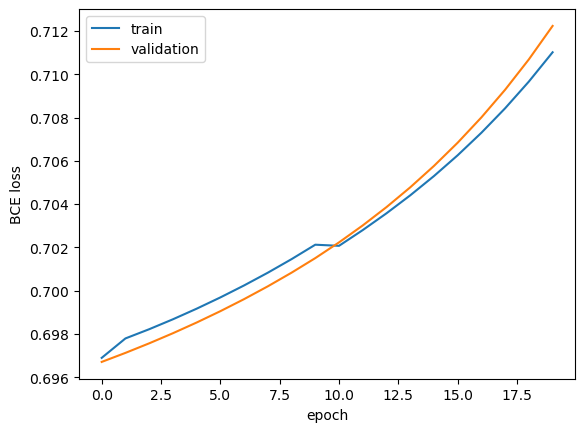

In [254]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE loss')

## embedding > RNN

In [ ]:
EmbedLayer = torch.nn.Embedding( num_embeddings = 5 , embedding_dim = 5 )

seq_embedded = EmbedLayer(seq_tensor)
seq_embedded

In [ ]:
output , _ = rnn(seq_embedded)
output